In [1]:
using Unitful
using Plots

In [2]:
pyplot()

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


Plots.PyPlotBackend()

In [3]:
push!(LOAD_PATH, "src")
using StopIon

# Bethe — Bloch model for cold matter

Here we test an implementation of a basic Bethe — Bloch model for non-ionized matter. This models gives the following energy loss of a projectile travelling through the matter:

$$
\left(\frac{dE}{ds}\right)_{\rm BB} = \frac{4\pi (Z_p e^2)^2}{m c^2}\frac{\rho}{M_t}Z_t
\frac{1}{\beta^2}\left(\ln \frac{2mc^2}{\langle I\rangle} + \ln\frac{\beta^2}{1-\beta^2} - \beta^2 - \frac{C}{Z_t}\right)
$$

where:
* $e$ is elementary charge
* $c$ is speed of light
* $m$ is electron mass
* $Z_p$ is charge state of the projectile
* $M_t$, $Z_t$ are mass and atomic number of target atoms
* $\rho$ is  density of stopping medium
* $\beta = v/c$ is velocity of the projectile
* $\langle I\rangle$ is average ionization potential
* $C$ is shell correction coefficient taken to be equal to $\frac12$ in our case

## Stopping of 2 MeV p⁺ in solid density aluminium

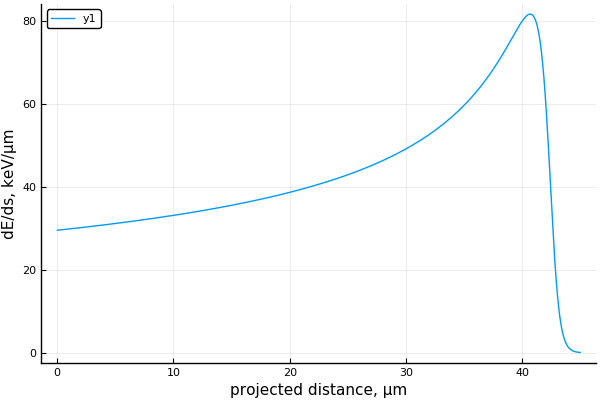

In [5]:
projectile = Particle(1.0, 1.0u"u")
target = Particle(13.0, 26.98u"u")
density = 2700.0u"kg/m^3"

x = collect(0:0.01:45)u"μm"

d = bethe_bloch(projectile, target, density, [2]u"MeV", [1], x)

plot(ustrip(x[1:end-1]), ustrip(uconvert.(u"keV", d))./diff(ustrip(x)))
xlabel!("projected distance, μm")
ylabel!("dE/ds, keV/μm")

This should be compared to a black curve at Fig. 1b of the paper [\[Kim et al., PRL 115, 054801 (2015)\]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.054801)

There is a notable difference in the height of the peak and stopping distance. It is believed that the reason is that our implementation doen't include Linhard — Scharff — Schiøtt (LSS) model which is more adequate for ultra slow projectiles.

## Stopping of 1.7 GeV C⁶⁺ ion in solid density copper

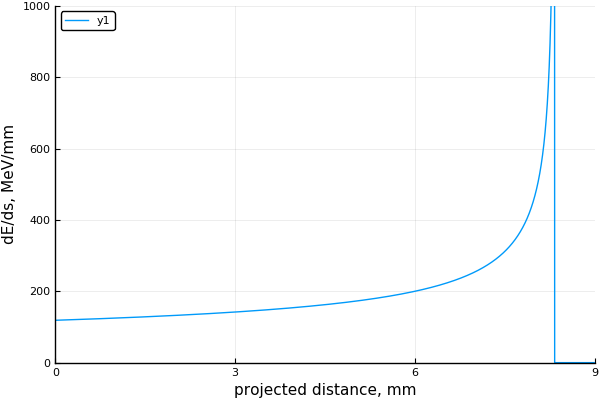

In [7]:
projectile = Particle(6.0, 12.0u"u")
target = Particle(29.0, 63.546u"u")
density = 8960.0u"kg/m^3"

x = collect(0:1:10000)u"μm"

d = bethe_bloch(projectile, target, density, [0, 1700]u"MeV", [0, 1], x)

plot(ustrip(x[1:end-1])/1000, ustrip(uconvert.(u"MeV", d))./diff(ustrip((uconvert.(u"mm", x)))), grid=true)
xlims!(0,9)
ylims!(0,1000)
xlabel!("projected distance, mm")
ylabel!("dE/ds, MeV/mm")

This should be compared to Fig. 4 of the paper [\[Fortov et al., Phys. Usp. 51 109–131 (2008)\]](https://doi.org/10.1070/PU2008v051n02ABEH006420)

It is seen that the conicidence is very high.

# Hybrid model for stopping in partially ionized and heated matter

This model is based on a scheme proposed in [\[Mehlhorn, J. Appl. Phys. 52, 6522 (1981)\]](http://dx.doi.org/10.1063/1.328602)

The energy loss of the projectile in the matter is given by the sum of contributions of bound and free electrons:
$$
\left(\frac{dE}{ds}\right) = \left(\frac{dE}{ds}\right)_{\rm bound} + \left(\frac{dE}{ds}\right)_{\rm free}
$$

$\left(\frac{dE}{ds}\right)_{\rm bound}$ is calculated by Bethe — Bloch model:
$$
\left(\frac{dE}{ds}\right)_{\rm bound} = \frac{4\pi (Z_p e^2)^2}{m c^2}\frac{\rho}{M_t}(Z_t - Z_{\rm eff})
\frac{1}{\beta^2}\left(\ln \frac{2mc^2}{\langle I\rangle_{\rm eff}} + \ln\frac{\beta^2}{1-\beta^2} - \beta^2 - \frac{C}{Z_t - Z_{\rm eff}}\right)
$$
the notable differences from the cold matter expression are
1) atomic number of target atoms $Z_t$ is decreased by their effective charge state $Z_{\rm eff}$
2) average ionization potential $\langle I\rangle$ is substituted by effective ionization potential $\langle I\rangle_{\rm eff}$ defined as follows
$$
\langle I\rangle_{\rm eff} = \langle I\rangle \frac{Z_t^2}{(Z_t - Z_{\rm eff})^2}
$$

We also take into account the effective change of projectile charge by applying the Brown — Moak expression:
$$
Z_p = Z_{p0}\left(1 - 1.034\exp\left[-137.04 \beta Z_{p0}^{-0.688}\right]\right)
$$

Contribution of free electrons is calculated based on binary collisions model with Chandrasekhar modifications and is given by the following expression
$$
\left(\frac{dE}{ds}\right)_{\rm free} = \frac{4\pi (Z_p e^2)^2}{m c^2}\frac{\rho}{M_t}Z_{\rm eff}
\frac{1}{\beta^2} G\left(\frac{mc^2\beta^2}{2T_e}\right)
\ln\left\{ \max\left[ \frac{mc^3 Z_p \beta}{e^2\omega_p u^2}, \frac{\hbar}{2mc^2 u} \right] \right\}
$$
where
* $G(x) = {\rm erf}\left(\sqrt{x}\right) - 2\sqrt{x/\pi}\exp(-x)$ is Chandrasekhar function
* $T_e$ is temperature of free electrons
* $\omega_p = \frac{4\pi e^2 \rho Z_{\rm eff}}{m M_t}$ is plasma frequency
* $u^2 = \frac{2T_e}{mc^2} + \beta^2$ is average relative velocity of electron — ion collisions


## Stopping of 2 MeV p⁺ in solid density aluminium at different temperatures

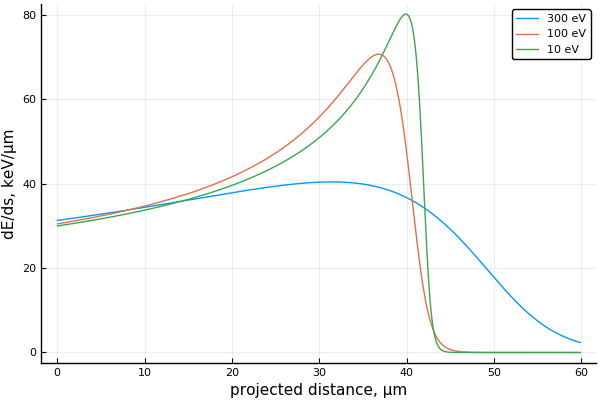

In [8]:
projectile = Particle(1.0, 1.0u"u")
target = Particle(13.0, 26.98u"u")
density = 2700.0u"kg/m^3"

x = collect(0:0.1:60)u"μm"

d1 = fixed_background(projectile, target, density, 300.0u"eV", 12.0, [2.0]u"MeV", [1], x)
d2 = fixed_background(projectile, target, density, 100.0u"eV", 8.0, [2.0]u"MeV", [1], x)
d3 = fixed_background(projectile, target, density, 10.0u"eV", 1.0, [2.0]u"MeV", [1], x)

plot(ustrip(x[1:end-1]), ustrip(uconvert.(u"keV", d1))./diff(ustrip(x)), label="300 eV")
plot!(ustrip(x[1:end-1]), ustrip(uconvert.(u"keV", d2))./diff(ustrip(x)), label="100 eV")
plot!(ustrip(x[1:end-1]), ustrip(uconvert.(u"keV", d3)./diff(ustrip(x))), label="10 eV")
xlabel!("projected distance, μm")
ylabel!("dE/ds, keV/μm")

This should be compared to Fig. 1b of the paper [\[Kim et al., PRL 115, 054801 (2015)\]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.054801)

As can be seen the qulitative coincidence is quite nice.

# Self-consistent model for stopping of intense ion beams

This model takes into account that intense ehough ion beams can substantially ionize and heat the stopping matter. Basically, the hybrid model described above is used except that $Z_{\rm eff}$ and $T_e$ can now locally vary in time. Their evolution is derived from energy conservation conditions:
$$
\frac{\rho}{M_t}\frac{d(Z_{\rm eff}\langle I\rangle_{\rm eff})}{dt} = \frac{dN}{dS}\beta c\left(\frac{dE}{ds}\right)_{\rm bound}
$$
$$
\frac{\rho}{M_t}\frac{d(Z_{\rm eff}T_e)}{dt} = \frac{dN}{dS}\beta c\left(\frac{dE}{ds}\right)_{\rm free}
$$
where
* $\frac{dN}{dS}$ is particle density flux of the ion beam

## Stopping of 5 MeV p⁺ in solid density aluminium at different current densities

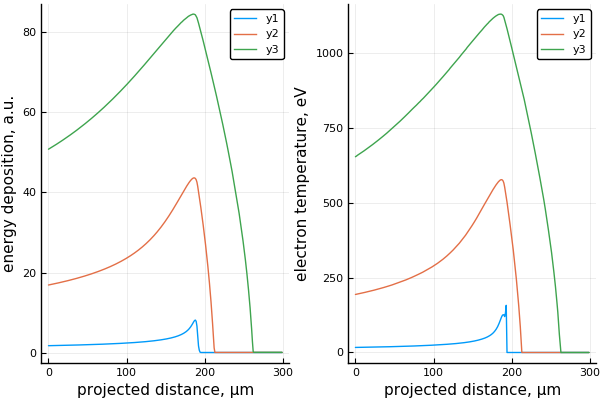

In [9]:
projectile = Particle(1.0, 1.0u"u")
target = Particle(13.0, 26.98u"u")
density = 2700.0u"kg/m^3"

x = collect(0:1:300)u"μm"
ε = collect(4.99:0.0001:5.01)u"MeV"
f = ones(length(ε))/length(ε)
τ = 3u"ps"

d1, Te1, Z1 = self_consistent(projectile, 1e10u"A/cm^2"*τ/Unitful.q, target, density, ε, f, x)
d2, Te2, Z2 = self_consistent(projectile, 1e11u"A/cm^2"*τ/Unitful.q, target, density, ε, f, x)
d3, Te3, Z3 = self_consistent(projectile, 3e11u"A/cm^2"*τ/Unitful.q, target, density, ε, f, x)

for i in eachindex(Te1)
    if Z1[i] < 0.1
        Te1[i] = 0u"eV"
    end
    if Z2[i] < 0.1
        Te2[i] = 0u"eV"
    end
    if Z3[i] < 0.1
        Te3[i] = 0u"eV"
    end
end

l = @layout [a ; b]

p1 = plot(ustrip(x[1:end-1]), ustrip(d1))
plot!(ustrip(x[1:end-1]), ustrip(d2))
plot!(ustrip(x[1:end-1]), ustrip(d3))
xlabel!("projected distance, μm")
ylabel!("energy deposition, a.u.")

p2 = plot(ustrip(x[1:end-1]), ustrip(Te1))
plot!(ustrip(x[1:end-1]), ustrip(Te2))
plot!(ustrip(x[1:end-1]), ustrip(Te3))
xlabel!("projected distance, μm")
ylabel!("electron temperature, eV")

plot(p1, p2)

This should be compared to Fig. 2 from the paper [\[Kim et al., PRL 115, 054801 (2015)\]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.054801)

The coincidence is only qualitative as we simulate 1D dynamics and impemented different model for a state of ionized matter.